In [1]:
import gymnasium as gym
import numpy as np
import time
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import pandas as pd
sns.set_theme(style="darkgrid")

In [2]:
def greedy(q_table, state):
    '''
    Greedy Policy

    Returns the index of the highest action value for current state
    '''
    return np.argmax(q_table[state,:])

def eps_greedy(env, q_table, state, exploration_rate):
    '''
    Epsilon-Greedy Policy

    Generates a random number between 0 and 1 and checks if the current exploration rate (epsilon) is lower.
    In case it is lower it returns the index of the highest action value for current state.
    Otherwise it chooses exploring and takes a random action
    '''
    exploration_rate_threshold = random.uniform(0, 1)
    if exploration_rate_threshold > exploration_rate:
        return greedy(q_table, state)
    else:
        return env.action_space.sample()


In [3]:

def train_q_learn(env, learning_rate, discount_rate, num_episodes, max_steps_per_episode, exploration_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate):
    '''
    Training a q-table with the Q-Learning algorithm
    '''
    rewards_all_episodes = []
    steps_all_episodes = []
    # Initialize the q-table with zero values
    q_table = np.zeros([env.observation_space.n, env.action_space.n])

    # Random generator
    rng =np.random.default_rng()

    # 2 For life or until learning is stopped
    for episode in range(num_episodes):
        # Reset the environment
        state, info = env.reset()
        step = 0
        rewards_current_episode  = 0
        
        for step in range(max_steps_per_episode):
            # 3. Choose an action a in the current world state (s)
            action = eps_greedy(env, q_table, state, exploration_rate)

            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done, truncated, info = env.step(action)

            # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            # qtable[new_state,:] : all the actions we can take from new state
            q_table[state, action] = q_table[state, action] +  learning_rate * (reward + discount_rate * np.max(q_table[new_state, :] - q_table[state, action]))
    
            
            rewards_current_episode  += reward
            step += 1
            
            # Our new state is state
            state = new_state
            
            # If done (if we're dead) : finish episode
            if done or truncated: 
                break
            
        # Reduce epsilon (because we need less and less exploration)
        exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate)*np.exp(-exploration_decay_rate*episode) 
        rewards_all_episodes.append(rewards_current_episode)
        steps_all_episodes.append(step)
    return q_table, rewards_all_episodes, steps_all_episodes
    


In [4]:

def train_sarsa(env, learning_rate, discount_rate, num_episodes, max_steps_per_episode, exploration_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate):
    '''
    Training a q-table with the SARSA algorithm
    '''
    rewards_all_episodes = []
    steps_all_episodes = []
    # Initialize the q-table with zero values
    q_table = np.zeros([env.observation_space.n, env.action_space.n])
    print(q_table.shape)

    # Random generator
    rng =np.random.default_rng()

    # 2 For life or until learning is stopped
    for episode in range(num_episodes):
        # Reset the environment
        state, info = env.reset()
        step = 0
        rewards_current_episode  = 0
        # Choose an action a in the current world state (s)
        action = eps_greedy(env, q_table, state, exploration_rate)

        for step in range(max_steps_per_episode):
            
            # 3. Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done, truncated, info = env.step(action)

            new_action = eps_greedy(env, q_table, new_state, exploration_rate)

            # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            # qtable[new_state,:] : all the actions we can take from new state
            q_table[state, action] = q_table[state, action]  +  learning_rate * (reward + discount_rate * q_table[new_state, new_action] - q_table[state, action])
    
            
            rewards_current_episode  += reward
            step += 1
            
            # Our new state is state
            # Our new action is action
            state = new_state
            action = new_action
            
            # If done (if we're dead) : finish episode
            if done or truncated: 
                break
            
        # Reduce epsilon (because we need less and less exploration)
        exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate)*np.exp(-exploration_decay_rate*episode) 
        rewards_all_episodes.append(rewards_current_episode)
        steps_all_episodes.append(step)
        
        if episode%50 == 0:
            print(exploration_rate)

        
    return q_table, rewards_all_episodes, steps_all_episodes
    


In [5]:
def eval_training(rewards_all_episodes, steps_all_episodes, num_episodes):
    '''
    Evaluates the training by calculating the means and plotting histograms of Rewards and Steps needed during training for 10 different subsets
    '''
    rewards_per_x_episodes = np.split(np.array(rewards_all_episodes),num_episodes/(num_episodes/10))
    steps_per_x_episodes = np.split(np.array(steps_all_episodes),num_episodes/(num_episodes/10))
    count = num_episodes/10

    print("********Average reward and steps per ",num_episodes/10 ," episodes********\n")
    for r, s in zip(rewards_per_x_episodes, steps_per_x_episodes):
        print(count, ": Reward = ", str(round(sum(r/(num_episodes/10)), 2)), ", Steps = ", str(round(sum(s/(num_episodes/10)), 2)))
        count += num_episodes/10


    fig, axes = plt.subplots(2, 5, figsize=(25, 10))
    fig.suptitle('Reward Histograms per ' + str(int(num_episodes/10)) + ' episodes during training')

    for i in range(len(rewards_per_x_episodes)):
        count += num_episodes/10
        sns.histplot(ax=axes[int(5%(i+1)/5), i-int(5%(i+1)/5)*5], x = rewards_per_x_episodes[i])
        axes[int(5%(i+1)/5), i-int(5%(i+1)/5)*5].set_title( str(len(rewards_per_x_episodes[i])*(i+1)-int(num_episodes/10)) + " - " + str(len(rewards_per_x_episodes[i])*(i+1)))

    fig, axes = plt.subplots(2, 5, figsize=(25, 10))
    fig.suptitle('Step Histograms per ' + str(int(num_episodes/10)) + ' episodes during training')

    for i in range(len(steps_per_x_episodes)):
        count += num_episodes/10
        sns.histplot(ax=axes[int(5%(i+1)/5), i-int(5%(i+1)/5)*5], x = steps_per_x_episodes[i])
        axes[int(5%(i+1)/5), i-int(5%(i+1)/5)*5].set_title( str(len(rewards_per_x_episodes[i])*(i+1)-int(num_episodes/10)) + " - " + str(len(rewards_per_x_episodes[i])*(i+1)))
    

    


In [6]:
def compare(rewards_all_episodes,s_rewards_all_episodes, steps_all_episodes, s_steps_all_episodes, num_episodes):

    df_rewards = pd.DataFrame(list(zip(rewards_all_episodes, s_rewards_all_episodes)), 
                                              columns =['Q_Rewards', 'S_Rewards'])
    
    df_steps = pd.DataFrame(list(zip(steps_all_episodes, s_steps_all_episodes)), 
                                              columns =['Q_Steps', 'S_Steps'])
    
    df_moving_rewards = df_rewards.rolling(10).mean().shift(-4)
    df_moving_steps = df_steps.rolling(10).mean().shift(-4)
    

    
    

    fig, axes = plt.subplots(2, 2, figsize=(25, 10))
    g = sns.lineplot(data = df_rewards,  ax = axes[0,0])
    g.set(yscale='symlog')
    g.lines[1].set_linestyle("solid")
    g.set_xlabel('episodes')
    leg = g.legend()
    leg_lines = leg.get_lines()
    leg_lines[1].set_linestyle("solid")
    g = sns.lineplot(data = df_steps, ax = axes[0,1])
    g.set(yscale="log")
    g.lines[1].set_linestyle("solid")
    g.set_xlabel('episodes')
    leg = g.legend()
    leg_lines = leg.get_lines()
    leg_lines[1].set_linestyle("solid")
    g = sns.lineplot(data = df_moving_rewards, ax = axes[1,0])
    g.set(yscale='symlog')
    g.lines[1].set_linestyle("solid")
    g.set_xlabel('episodes')
    leg = g.legend()
    leg_lines = leg.get_lines()
    leg_lines[1].set_linestyle("solid")
    g = sns.lineplot(data = df_moving_steps, ax = axes[1,1])
    g.set(yscale="log")
    g.lines[1].set_linestyle("solid")
    g.set_xlabel('episodes')
    leg = g.legend()
    leg_lines = leg.get_lines()
    leg_lines[1].set_linestyle("solid")


In [7]:
def compare_plot(x,y,plt_type):
    x_series = pd.Series(x)
    x_series = x_series.rolling(15).mean()
    plt.plot(x_series)

    y_series = pd.Series(y)
    y_series = y_series.rolling(15).mean()
    plt.plot(y_series)

    plt.legend(["Q-Learning", "SARSA"])
    plt.xlabel("Episodes")
    plt.ylabel(plt_type)

    plt.yscale("symlog")
    plt.show()

In [8]:
def visualise(env, q_table, max_steps_per_episode, num_vis_episodes=3):
    '''
    Function which simulates and displays the game a certain amount of times.
    '''
    for episode in range(num_vis_episodes):
        state, _ = env.reset()
        print("********EPISODE ", episode+1, "********\n\n\n\n")
        time.sleep(1)

        for step in range(max_steps_per_episode):
            clear_output(wait=True)
            print(env.render())
            time.sleep(0.3)

            action = np.argmax(q_table[state,:])
            new_state, reward, done, truncated, _ = env.step(action)
            if done or truncated: 
                clear_output(wait=True)
                print(env.render())
                if reward > 0:
                    print("****You reached the goal!****")
                    time.sleep(3)
                else:
                    print("****Something else happened!****")
                    time.sleep(3)
                    clear_output(wait=True)
                break
            state = new_state
        

In [9]:
def eval_test(env, num_test_episodes, max_steps_per_episode, q_table):
    total_steps, total_penalties, total_reward, total_errors = 0, 0, 0, 0

    for episode in range(num_test_episodes):
            state, _ = env.reset()

            for step in range(max_steps_per_episode):
                total_steps += 1
                action = np.argmax(q_table[state,:])
                new_state, reward, done, truncated, _ = env.step(action)
                total_reward += reward
                if reward == -10:
                    total_penalties += 1

                if done or truncated: 
                    if reward > 0:
                        break
                    else:
                        total_errors += 1
                        break
                
                if step == max_steps_per_episode  - 1:
                    total_errors += 1

                state = new_state
    
    print("Avg Steps : ", str(round(total_steps/num_test_episodes, 2)))
    print("Total Penalties: ", str(int(total_penalties)))
    print("Avg Reward : ", str(round(total_reward/num_test_episodes, 2)))
    print("Total Errors: ", str(int(total_errors)))

In [17]:
# Hyperparameters
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

# env = gym.make('FrozenLake-v1', desc=generate_random_map(size=4), map_name="4x4", is_slippery=False, render_mode='ansi').env # 
env = gym.make("Taxi-v3", render_mode='ansi').env
# env = gym.make("CliffWalking-v0", render_mode="ansi")

num_episodes = 3000
max_steps_per_episode = 1000

learning_rate = 0.1
discount_rate = 0.99

exploration_rate = 1 # epsilon
max_exploration_rate = 1
min_exploration_rate = 0.05
exploration_decay_rate = 0.005

In [18]:
q_table, reward_list, step_list = train_q_learn(env, learning_rate, discount_rate, num_episodes, max_steps_per_episode, exploration_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate)
s_q_table, s_reward_list, s_step_list = train_sarsa(env, learning_rate, discount_rate, num_episodes, max_steps_per_episode, exploration_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate)


(500, 6)
1.0
0.7898607439178347
0.6262041267270018
0.49874822510396394
0.3994854691128702
0.32217955701718054
0.2619736521410083
0.21508524627792286
0.17856851907478205
0.15012926333377113
0.12798074869270387
0.11073146814637219
0.09729771494947075
0.08683549744013591
0.07868751425120257
0.07234185856320866
0.06739985694429747
0.0635510222135493
0.06055354671133019
0.05821911044296461
0.056401049649131195
0.054985142479222315
0.05388243286654087
0.053023641756684184
0.052354814567833044
0.05183393142941633
0.051428267233328696
0.05111233563975162
0.050866287867276795
0.050674665669400425
0.050525430151640446
0.050409205413546904
0.05031868949650739
0.05024819562943659
0.050193294950560116
0.05015053825885997
0.05011723931388235
0.05009130606945833
0.05007110923839332
0.050055379930544326
0.050043129933274366
0.050033589625807895
0.05002615962688226
0.05002037313790076
0.050015866615750734
0.05001235693277137
0.0500096235889187
0.05000749485858584
0.050005837001735665
0.0500045458615225

In [165]:
%matplotlib qt5
compare(reward_list, s_reward_list,  step_list, s_step_list, num_episodes)

c:\Users\BaneBoy\Documents\Projekte\AML_Taxi\env\lib\site-packages\ipykernel\eventloops.py:128: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  el.exec() if hasattr(el, 'exec') else el.exec_()


In [19]:
%matplotlib qt5
compare_plot(reward_list, s_reward_list,  "Rewards")

********Average reward and steps per  200.0  episodes********

200.0 : Reward =  -1209.74 , Steps =  386.32
400.0 : Reward =  -148.62 , Steps =  92.17
600.0 : Reward =  -45.38 , Steps =  46.13
800.0 : Reward =  -13.17 , Steps =  27.65
1000.0 : Reward =  -2.02 , Steps =  19.65
1200.0 : Reward =  1.6 , Steps =  16.93
1400.0 : Reward =  3.65 , Steps =  15.24
1600.0 : Reward =  3.89 , Steps =  14.95
1800.0 : Reward =  5.92 , Steps =  13.78
2000.0 : Reward =  5.26 , Steps =  14.03


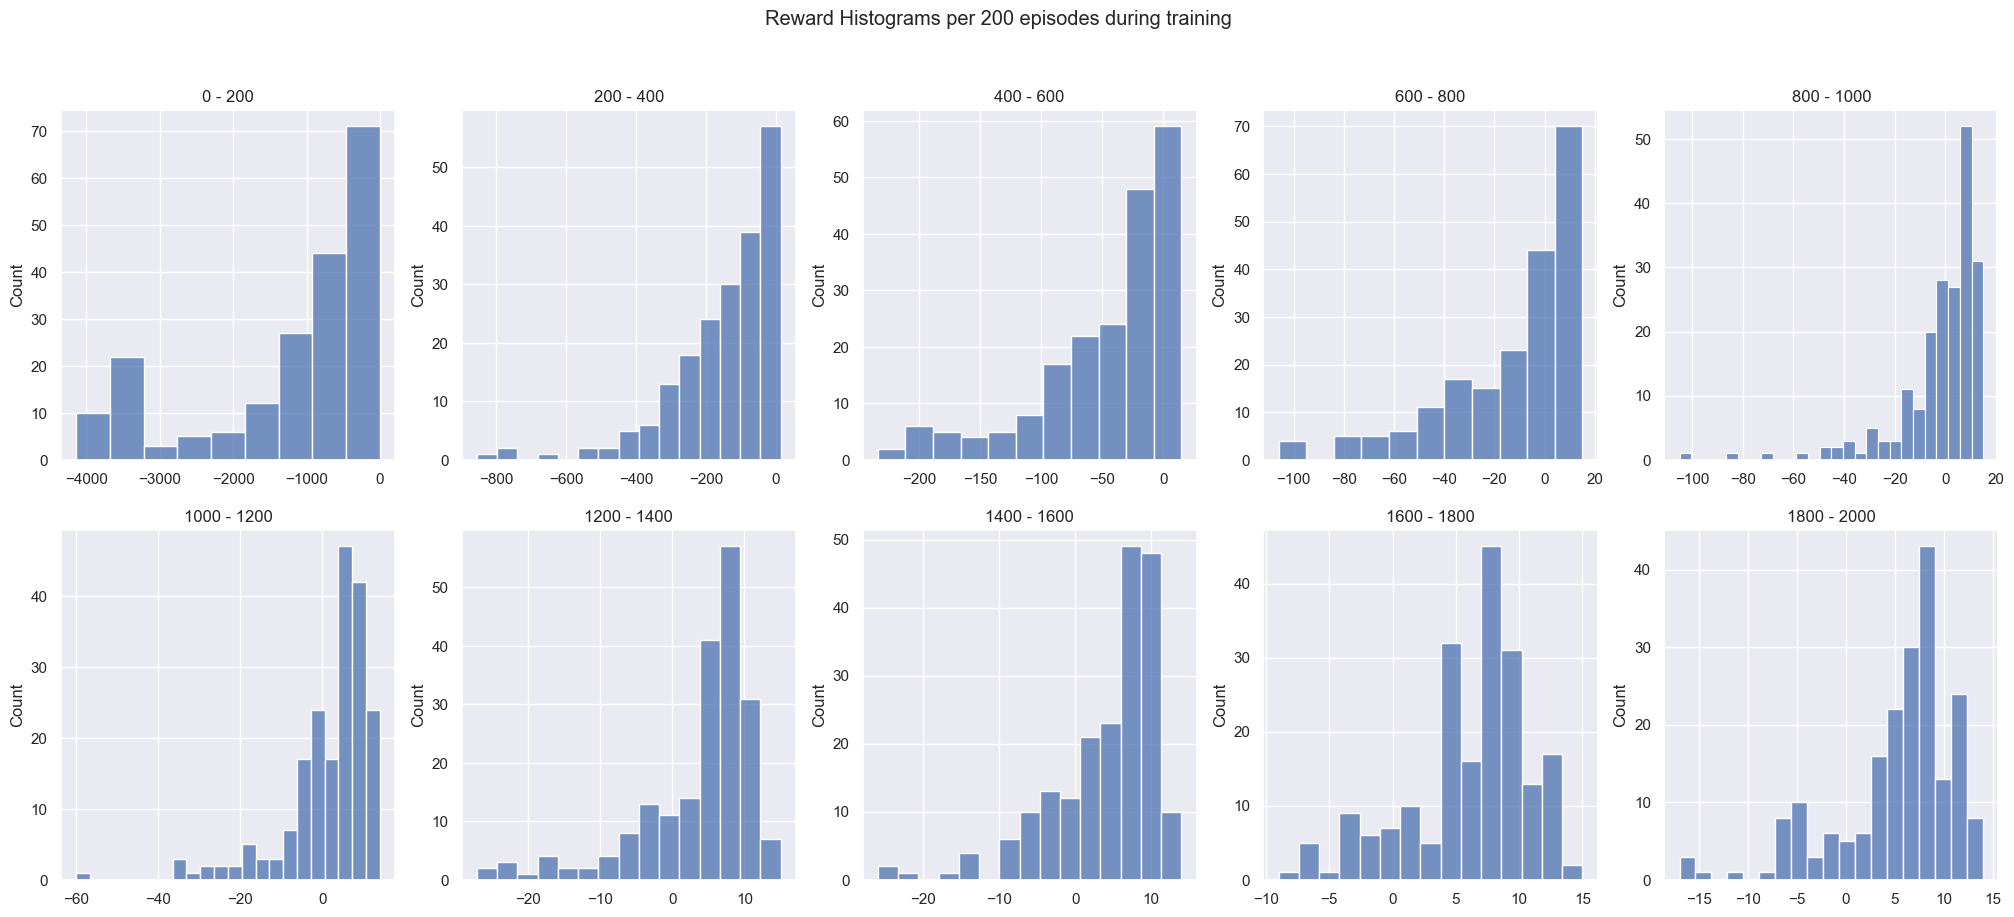

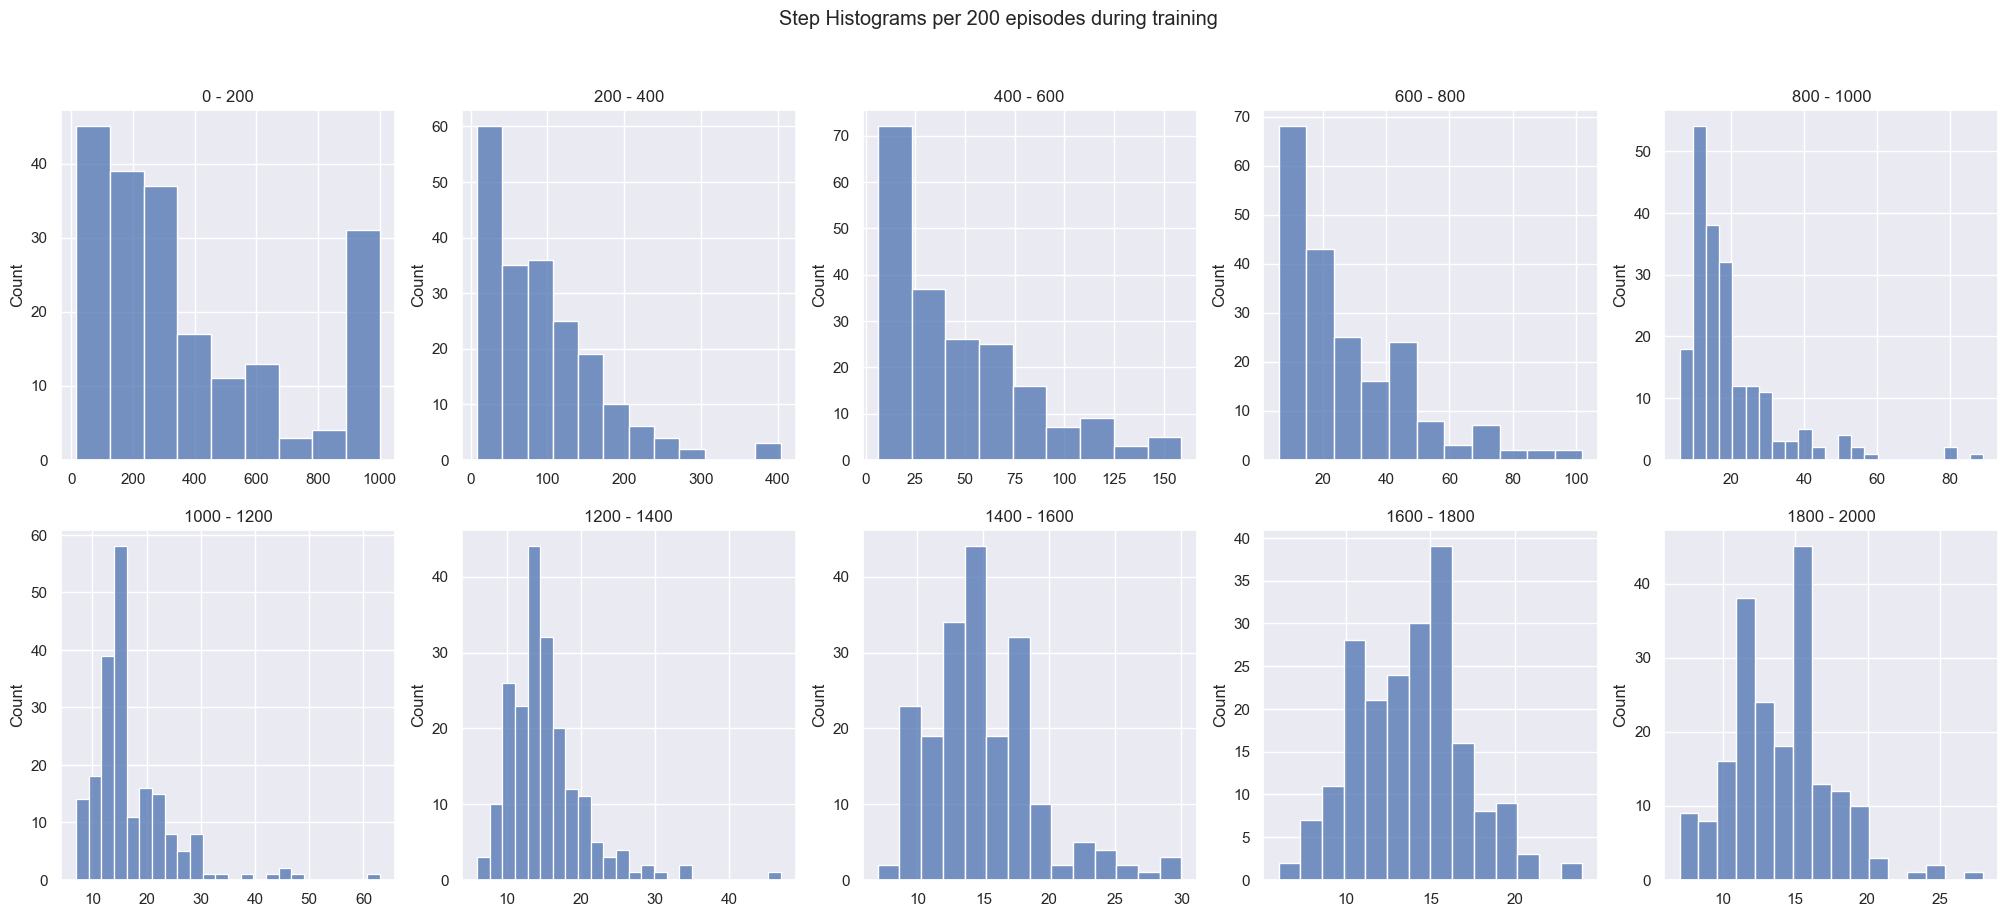

In [15]:
eval_training(reward_list, step_list, num_episodes)

In [157]:
visualise(env, q_table, max_steps_per_episode)

  (Left)
SFHFFHFH
FFFFFFFF
HFFHFFFF
FHFFHFFF
FFFFFHFH
FFFFFHFF
HHFHFFFH
FFFFFFFG



KeyboardInterrupt: 

In [47]:
eval_test(env, num_test_episodes=100, max_steps_per_episode=max_steps_per_episode, q_table=s_q_table)

Avg Steps :  17.0
Total Penalties:  0
Avg Reward :  -17.0
Total Errors:  100


NameError: name 'observation' is not defined